## Progress Report

In [33]:
import pandas as pd
from IPython.display import display


### Overview of Progress

At this stage, the image data pre-preocessing and the CNN have been completed. As the image data took longer than expected to prepare (mostly due to my inexperience in this area), less time has been dedicated to the modelling process. However, now that the CNN has been configured, the Multi-layer perceptron using the environmental data should take less time to complete, as I am more comfortable with traditional data structures. Finally, the task I am still unsure about completing is how I will "merge" these two models together. More of that will be explained in the **Next Steps** section. 


### Data Processing

To review, the data for this project comes from three places. First, there is the *Master Table*, which not only connects each TIF file to its corresponding CSV, but also contains environmental information about each water sample (from which each TIF mosaic is created). Second, there are the *TIF files*, which are the FlowCam-created mosaics of each plankton particle in a given sample of water. Finally, there are the corresponding *CSV files*, which contain the class labels for each particle, as well as various geometric factors (e.g. intensity, roughness, symmetry). 


The following data processing steps were taken:

1. Select random sample of 50 TIF files from the Master Table, 
    -  Note that originally, I sampled 50 CSV files -- but this created issues later on with merging because the Master Table is unique at the TIF level, not the CSV level.
2. Create row-binded file of CSVs for all selected TIFs 
3. Merge this new CSV with the Master Table (on the TIF file name). Now there is one dataset with all geometric and environmental information. 
4. Download corresponding TIF files. For sake of time, only samples from Huron were collected. 
5. For each TIF, split the mosaic into the individual particles. 
6. Oversample (sample with replacement) from the underrepresented classes (Chydoridae and Daphnia).
7. Split into training, validation, and testing sets. 
8. Add augmented images from the underrepresented classes to the training set. Leave validation and test sets free of augmented images. 
9. Resized images to be 300x300 for CNN. 
10. One-hot encode class labels for CNN training. 


### Oversampling and Data Augmentation for Class Imbalance

In our unprocessed, raw random sample (Step 1) the class counts were as follows:

In [34]:
data_cleaned = pd.read_csv("data_cleaned.csv")
class_counts = pd.DataFrame(data_cleaned["Class"].value_counts())
display(class_counts)

,count
Class,
Calanoid_1,3917
Bosmina_1,341
Herpacticoida,156
Chironomid,121
Chydoridae,2
Daphnia,1


Because we have so few instances of Chydoridae and Daphnia, in order to ensure our model adequately learns these classes, we will strategically create our training, testing, and validation sets to make sure these classes are represented. 

First, we will **oversample** these two classes. Before splitting the dataset, we will sample from these classes with replacement to increase their prevalence in the dataset overall. We did this to ensure 100 instances of each of these classes in our oversampled dataframe. Then, we split into training, testing, and validation sets.

After oversampling, we will **augement** images of the two underrepresented classes in the training dataset. This means we will add images to the training set that are augemented versions of existing images. Augementations include stretching, rotating, rescaling, zooming, and vertical/horiztonal shifts. Using ImageDataGenerator function from Tensorflow, some random combination of these augmentations will be applied to the images of the undersampled classes. The resulting training dataset will have a more even distribution of classes of each type. 

Below are examples of augmented images. 

In [37]:
from PIL import Image

path_aug = "/Users/adelelauzon/Desktop/MSc/STA5243/2453Github/vignettes/20190514_FISHI_152_2mm_rep2_AO_000039_vign000200_aug_0_3348.png"
path_orig = "/Users/adelelauzon/Desktop/MSc/STA5243/2453Github/vignettes/20190514_FISHI_152_2mm_rep2_AO_000039_vign000200.png"
orig = Image.open(path_orig)
aug = Image.open(path_aug)



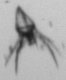

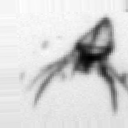

In [38]:
display(orig)
display(aug)

The resulting class breakdown of the training, testing, and validation datasets is as follows: 


In [39]:
train = pd.read_csv("train.csv")
class_counts_train = pd.DataFrame(train["Class"].value_counts())
class_counts_train = class_counts_train.rename(columns={'count': 'Train'})

test = pd.read_csv("test.csv")
class_counts_test = pd.DataFrame(test["Class"].value_counts())
class_counts_test = class_counts_test.rename(columns={'count': 'Test'})

val = pd.read_csv("val.csv")
class_counts_val = pd.DataFrame(val["Class"].value_counts())
class_counts_val = class_counts_val.rename(columns={'count': 'Validation'})

full_counts = pd.merge(class_counts_train, class_counts_test, on = "Class", how="outer")
full_counts = pd.merge(full_counts, class_counts_val, on = "Class", how="outer")

display(full_counts)

,Train,Test,Validation
Class,,,
Bosmina_1,203,68,68
Calanoid_1,2142,715,714
Chironomid,64,21,21
Chydoridae,183,20,21
Daphnia,183,20,20
Herpacticoida,77,26,26


### Building CNN

Based on another paper classifying plankton from FlowCam imagery (Bonin-Font et al., 2024), I opted to use EfficientNetv2, a pretrained model from the Tensorflow library. Because this is a transfer learning problem, we used the pretrained weights (the model was trained on ImageNet originally). All layers were frozen except for the top layer, which is the only layer that was trained. A large learning rate was used (exp{-2}). 25 training epochs were used. The choice of these parameters was guided by the [EfficientNet documentation](https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/). 

The results of this approach (only unfreezing and training the top layer) are presented below. 

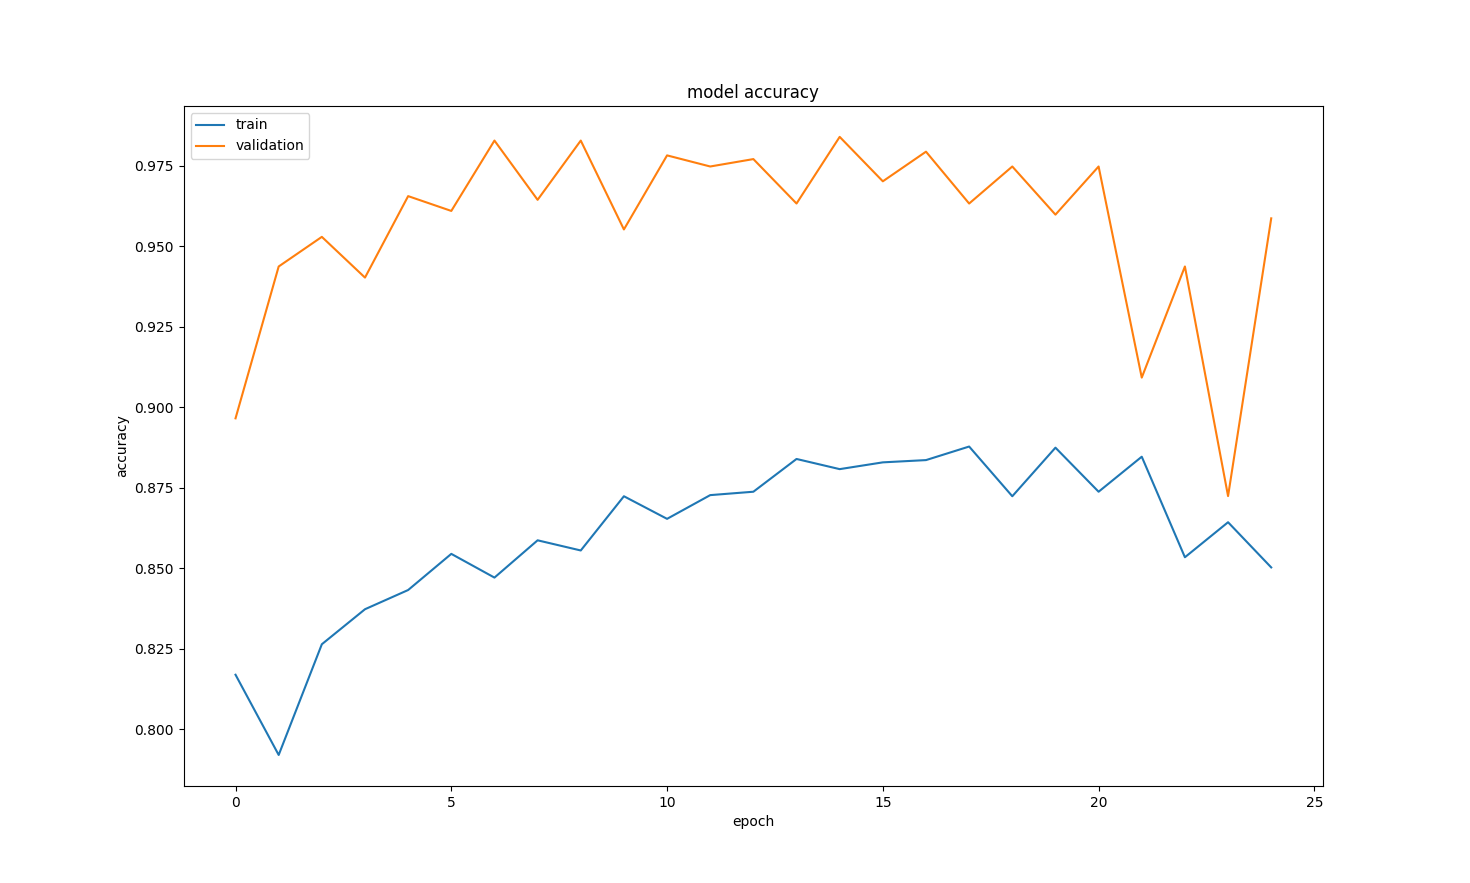

In [40]:
hist_path = "/Users/adelelauzon/Desktop/MSc/STA5243/2453Github/NewHist.png"
hist = Image.open(hist_path)
display(hist)

The test accuracy of the model was **96%**. Given the plot above, while the final accuracy was >80% for the validation set, something occurred during the 24th epoch that decreased accuracy substantially. Further investigation is needed to identify what happened here. 

A possible next step would be to unfreeze more layers and fit the model using a smaller learning rate. However, given the decent performance of the classifier in the previous step, this may only yield marginal gains in accuracy. 

### Next Steps

The two biggest next steps are building the MLP, and then somehow connecting the results of the CNN and the MLP. Based on the paper by Kerr et al, it looks like if we build each model, and then remove the softmax layer (the last layer) and feed both models into a connected model, we can get a single prediction output. Unfortunately, the code from the paper seems to be deprecated, so I'll have to look elsewhere to get an idea for how to accomplish this step. 
